# GHMM Example

In [2]:
%load_ext tensorboard

In [2]:
import sys
sys.path.append("C:\\Users\\Admin\\Python\\filterflow")

In [3]:
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn
import tensorflow as tf
import tensorflow_probability as tfp
import time

seaborn.set()

The goal of this notebook is to demonstrate how to use FilterFlow to do likelihood and state inference on a simple Gaussian Hidden Markov Model. In this notebook we will consider the noisy resonator defined in p62-63 of "Bayesian fitering and smoothing, Simo Sarkka"

$$
\begin{align*}
            \mathbf{x_k} &= \begin{bmatrix}
                \cos(\omega)         & \frac{\sin(\omega)}{\omega} \\
                -\omega \sin(\omega) & \cos(\omega) \\
            \end{bmatrix} \mathbf{x_{k-1}} + q_{k-1} \\
            y_k &=  
            \begin{bmatrix}
                1 & 0
            \end{bmatrix} \mathbf{x_k} + r_k
\end{align*}
$$

where the noise and observation error terms $q_{k-1}$ and $r_k$ are i.i.d centered normal distributions with $q_k$ covariance matrix given by 
$$
    \mathbf{Q} = \begin{bmatrix}
            \frac{q^c \omega - q^c \cos(\omega) \sin(\omega)}{2 \omega^2} &
            \frac{q^c \sin(\omega) ^2 }{2 \omega^3}   
        \\
            \frac{q^c \sin(\omega) ^2 }{2 \omega^3}  &
            \frac{q^c \omega + q^c \cos(\omega) \sin(\omega)}{2 \omega} 
    \end{bmatrix} 
$$

the parameters are given by
$
\omega = 0.5, q^c = 0.01, r_k = \mathcal{N}(0, 0.1)
$
and the initial location $\mathbf{x_0} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

In [4]:
class ResonatorOutput(object):
    __slots__ = ('observations', 'states')
    def __init__(self, observations: np.ndarray, states: np.ndarray):
        self.observations = observations
        self.states = states

# Definition of the dynamic model
class NoisyResonator(object):
    def __init__(self, 
                 angular_velocity: float = 0.5, 
                 spectral_density: float = 0.01, 
                 measurement_variance: float = 0.1,
                 initial_location: np.ndarray = None,
                 random_state: np.random.RandomState = None,
                 seed: int = None):
        """
        Construction method
        Parameters
        ----------
        angular_velocity : float
            value of :math:`\omega`
        spectral_density: float
            value of :math:`q^c`
        measurement_variance: float 
            variance of :math:`r_k`
        initial_location: ndarray
            :math:`x_0`. If not provided will be np.array([0, 0.1], dtype=np.float64)
            1D array of size 2, for the sake of this exercise it will be deterministic
        random_state: RandomState
            for reproducibility, if not provided, np.random.RandomState(seed)
        seed: int
            for reproducibility, if not provided, None (seed will depend on clock time and architecture)
        """
        
        
        self.angular_velocity = angular_velocity
        self.spectral_density = spectral_density
        self.measurement_variance = measurement_variance
        self.initial_location = np.asanyarray(initial_location, dtype=np.float64) if initial_location is not None\
            else np.array([0., 0.1], dtype=np.float64)
        self.random_state = random_state if random_state is not None else np.random.RandomState(seed)
        
        assert self.initial_location.shape == (2,), "initial location needs to be of shape (2,)"
        
        self._covariance = self._compute_covariance_matrix()
        self._lower_triang = np.linalg.cholesky(self._covariance)
        self._transition_matrix = self._compute_transition_matrix()
        self._observation_matrix = np.array([1, 0], dtype=float)
        
    def _compute_covariance_matrix(self):
        w = self.angular_velocity
        qc = self.spectral_density
        cos_w = math.cos(w)
        sin_w = math.sin(w)
        if abs(w) < 1e-5:
            # to avoid numerical problems we take the limit
            q_11 = qc/6
            q_12 = qc/2
            q_21 = q_12
            q_22 = qc
        else:
            q_11 = 0.5*(qc * w - qc * cos_w * sin_w)/math.pow(w, 3)
            q_12 = 0.5*(qc * sin_w * sin_w)/math.pow(w, 2)
            q_21 = q_12
            q_22 = 0.5*(qc * w + qc * cos_w * sin_w)/w
        matrix = np.array([[q_11, q_12], 
                           [q_21, q_22]], dtype=float)
        return matrix
    
    def _compute_transition_matrix(self):
        w = self.angular_velocity
        cos_w = math.cos(w)
        sin_w = math.sin(w)
        if abs(w) < 1e-5:
            # to avoid numerical problems we take the limit
            m_11 = 1.
            m_12 = 1.
            m_21 = 0.
            m_22 = 1.
        else:
            m_11 = cos_w
            m_12 = sin_w/w
            m_21 = -w * sin_w
            m_22 = cos_w
        matrix = np.array([[m_11, m_12], 
                           [m_21, m_22]], dtype=float)
        return matrix
                
    def _sample_latent_state(self, N):
        latent_state = self.initial_location
        random_samples = self.random_state.randn(N-1, 2)
        latent_state_ts = np.empty((N, 2), dtype=np.float64)
        latent_state_ts[0, :] = latent_state
        for i, random_sample in enumerate(random_samples):
            latent_state = self._transition_matrix @ latent_state
            latent_state += self._lower_triang @ random_sample
            latent_state_ts[i+1, :] = latent_state
        return latent_state_ts
            
    @property
    def covariance(self):
        return self._covariance
    
    @property
    def transition_matrix(self):
        return self._transition_matrix
    
    @property
    def observation_matrix(self):
        return self._observation_matrix
        
    def _get_observation(self, latent_space_ts):
        no_noise = np.einsum('j,ij->i', self._observation_matrix, latent_space_ts)
        return no_noise + self.random_state.normal(0., math.sqrt(self.measurement_variance), latent_space_ts.shape[0])
    
    def sample(self, N: int) -> ResonatorOutput:
        """
        Samples n steps of the model
        Parameters
        ----------
        N: int
            total number of steps
        
        Returns
        -------
        ResonatorOutput from the parametrised process
        """
        latent_time_series = self._sample_latent_state(N)
        observations = self._get_observation(latent_time_series)
        return ResonatorOutput(observations, latent_time_series)

In [5]:
M = 150
resonator = NoisyResonator(seed=42)
linspace = np.linspace(0, M, M)
example = resonator.sample(M)

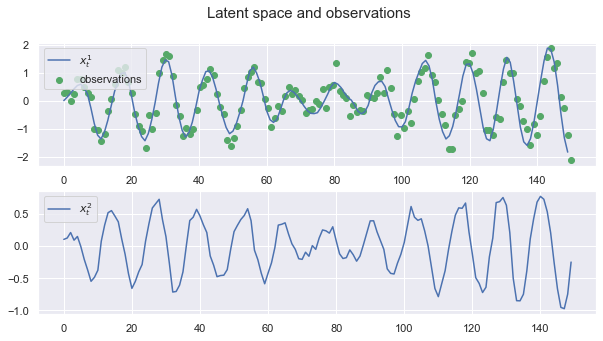

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, example.observations, marker='o', color='g', label='observations')
axes[0].plot(example.states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(example.states[:, 1], color='b', label='$x^2_t$')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [7]:
from filterflow.filter import ParticleFilter
from filterflow.base import State, ObservationBase, InputsBase
from filterflow.observation.linear import LinearObservation, LinearObservationModel
from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal.base import BootstrapProposalModel
from filterflow.resampling.criterion import NeffCriterion
from filterflow.resampling.standard.systematic import SystematicResampler


In [8]:
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
cwd = os.getcwd()
logdir = f'{cwd}\\logs\\{stamp}'
writer = tf.summary.create_file_writer(logdir)


In [9]:
n_particles = tf.constant(100)
dimension = tf.constant(2)
batch_size = tf.constant(1)

weights = tf.ones((batch_size, n_particles), dtype=float)/tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
state = State(batch_size, n_particles, dimension, initial_particles, log_weights= tf.math.log(weights), weights=weights, log_likelihoods=log_likelihoods)

In [11]:
observation_error = tfp.distributions.MultivariateNormalDiag([0.], tf.constant(np.array([resonator.measurement_variance], dtype=np.float32)))
random_walk_noise = tfp.distributions.MultivariateNormalFullCovariance([0., 0.], resonator.covariance.astype(np.float32))

W0327 13:37:18.841196 21344 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_probability\python\distributions\distribution.py:284: MultivariateNormalFullCovariance.__init__ (from tensorflow_probability.python.distributions.mvn_full_covariance) is deprecated and will be removed after 2019-12-01.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [12]:
observation_model = LinearObservationModel(tf.constant(resonator.observation_matrix.astype(np.float32).reshape(1, 2)), observation_error)
transition_model = RandomWalkModel(tf.constant(resonator.transition_matrix.astype(np.float32)), random_walk_noise)
proposal_model = BootstrapProposalModel(transition_model)
resampling_criterion = NeffCriterion(0.5, is_relative=True)
resampling_method = SystematicResampler(on_log=True)

In [13]:
particle_filter = ParticleFilter(observation_model, transition_model, proposal_model, resampling_criterion, resampling_method)

In [13]:
import numpy as np
import bqplot.pyplot as plt
from bqplot import LinearScale, Axis, Lines, Bars, Figure
axes_options = {'x': {'label': 't'}, 'y': {'label': 'cos'}}
fig = plt.figure(animation_duration=0)
lines = plt.plot(
                x=np.linspace(0, len(example.observations), len(example.observations)), 
                y=example.observations, 
                colors=['red'], 
                axes_options=axes_options)
scatt = plt.scatter([], [], colors=['blue'], axes_options=axes_options)
plt.set_lim(-2., 2., 'y')
plt.set_lim(0, len(example.observations), 'x')

fig


Figure(axes=[Axis(label='t', scale=LinearScale(max=150.0, min=0.0)), Axis(label='cos', orientation='vertical',…

In [46]:
import attr

@tf.function
def filter_run(particle_filter, initial_state, observations):
    ta = tf.TensorArray(float, size=len(observations), dynamic_size=False)
    state = attr.evolve(initial_state)
    for i in range(len(observations)):
        observation = LinearObservation(observations[i])
        state = particle_filter.propose_and_update(state, observation, None)
    return state               



In [47]:
tf_observations = tf.constant(example.observations.astype(np.float32))

In [48]:
%timeit result = filter_run(particle_filter, state, tf_observations)

24.7 ms ± 628 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
result

State(batch_size=<tf.Tensor: shape=(), dtype=int32, numpy=1>, n_particles=<tf.Tensor: shape=(), dtype=int32, numpy=100>, dimension=<tf.Tensor: shape=(), dtype=int32, numpy=2>, particles=<tf.Tensor: shape=(1, 100, 2), dtype=float32, numpy=
array([[[-1.4770843 , -0.23049477],
        [-1.3623359 , -0.02462593],
        [-1.4711714 , -0.15024565],
        [-1.5268155 , -0.19923317],
        [-1.4074007 , -0.00226282],
        [-1.5746514 , -0.33876425],
        [-1.6032704 , -0.30505097],
        [-1.728637  , -0.50460374],
        [-1.6651195 , -0.34001094],
        [-1.6324072 , -0.17635101],
        [-1.4741517 , -0.2540988 ],
        [-1.5547539 , -0.38987246],
        [-1.782639  , -0.3015496 ],
        [-1.7865349 , -0.3616068 ],
        [-1.9184207 , -0.4577731 ],
        [-1.4819833 , -0.22628082],
        [-1.4318744 , -0.16804418],
        [-1.4721593 , -0.16683275],
        [-1.4729973 , -0.23058054],
        [-1.7425867 , -0.3615573 ],
        [-1.7666202 , -0.42784953],
     

In [15]:
# tf.summary.trace_on(graph=True, profiler=True)
jitter = np.random.normal(0., 0.5, n_particles)
for t, observation_value in enumerate(example.observations):
    observation = LinearObservation(tf.constant(np.array([observation_value], dtype=np.float32)))
    input_ = None
    state = particle_filter.propose_and_update(state, observation, input_)
    weights = state.weights.numpy().squeeze()
    particles = state.particles.numpy()

    time.sleep(0.1)
# tic = time.time()
# for _ in range(10):
#     for t, observation_value in enumerate(example.observations):
#         observation = LinearObservation(tf.constant(np.array([observation_value], dtype=np.float32)))
#         input_ = None
#         state = particle_filter.propose_and_update(state, observation, input_)
# toc = time.time()

In [15]:
with writer.as_default():
    tf.summary.trace_export(
        name="filter",
        step=0,
        profiler_outdir=logdir)

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[4.1764630e-18, 6.4455097e-31, 3.7510620e-33, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 8.1842578e-27, 1.7765905e-29,
        7.3775742e-35, 0.0000000e+00, 4.7428191e-25, 0.0000000e+00,
        9.9188617e-21, 2.2747997e-22, 1.3073957e-35, 0.0000000e+00,
        0.0000000e+00, 7.3006964e-35, 1.9553478e-27, 0.0000000e+00,
        8.8859272e-27, 2.7619510e-16, 1.8009101e-28, 2.3936607e-26,
        2.3826290e-33, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 4.6095527e-35, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.8613538e-29, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.9809459e-38, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00

In [17]:
tic = time.time()
for t, observation_value in enumerate(example.observations):
#     observations.append(observation_value)
    observation = LinearObservation(tf.constant(np.array([observation_value], dtype=np.float32)))
    input_ = None
    state = particle_filter.propose_and_update(state, observation, input_)
#     weights = state.weights.numpy().squeeze()
#     particles = state.particles.numpy()
#     scatt.x = t + jitter
#     scatt.y = particles[0, :, 0]
#     scatt.s = weights * 10.
#     time.sleep(0.3)
#     weights.append(state.weights.numpy())
#     particles.append(state.particles.numpy())
toc = time.time()

1.0000012

In [18]:
logdir

[-0.82153976]

In [19]:
%tensorboard --logdir C:\\Users\\Admin\\Python\\filterflow\\notebooks\\examples\\logs\\20200326-103247